Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline.

V3.1 PID neural network takes in previous y value as parameter

V3.2 Take absolute value of Kp, Ki, Kd

V3.3 PID control the plant while training with a manually tuned PID controller

V3.4 Remove 3.3 changes. Initialize bias term with ones

V3.5 Added another layer to model neural network. Initialized only model nn with zeros. Increased NN model size to 16

V3.6 Changed to Adam Optimizer. Increased model to 3 layers: 16, 8 ,4. Added 10 epochs. Lowered learning rate

V3.7 Allowing model nn weight updates in online training

V3.8 Remove 3.7 changes. Added layer to PID nn: 8, 3. Switched to leaky relu in model nn

V3.9 Model hl: 4, 8, 8, 4. PID hl: 8, 5, 3

(V4.0 LSTM didn't show much difference in model learning)

V3.X.0 Split PID neural network into 3 separate networks

V3.X.1 input error into PID neural network. Switched PID to leaky relu. Modified offline training signal to combine sin and square

V3.X.2 Minimize loss E(y, r, y_m). Rolling offline and online training into online training

V3.X.3 Removed 3.X.2 changes. Changed gain update to delta. Fixed resetting y_0. Fixed PID update (e was not self.e)

V3.X.4 Removed delta gain update. Use learned PID in offline training. Reduced steps by half.

V3.X.5 Removed 3.X.0 changes

V3.X.6 Removed 3.X.5 changes. Removed limit on I term. Increased step x4, increased square interval to 500. Start square wave at 0

V3.X.7 Use difference between plant and model as PID nn input

V3.X.8 Removed 3.X.7 change, combine offline and online training into one. Reduced learning rate to 0.001 for model. Kept lr at 0.01 for PID

V3.X.9 add previous plant and previous model output to input of PID nn. PID nn hidden layers: from 8,3 to 3,2. PID lr to 0.001

V3.X.9.D Removed 3.X.9 changes. Changed PID gain update to delta. 

V3.Y.0 Reverted back to 3.X.6. Put previous u values into model NN input.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 6000

In [3]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
#         self.I_max = 20
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp=None, Ki=None, Kd=None):
        if Kp is not None and Ki is not None and Kd is not None:
            self.Kp = Kp
            self.Ki = Ki
            self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = self.e
        
        self.I += self.e * delta_time

#         if (self.I < -self.I_max):
#             self.I = -self.I_max
#         elif (self.I > self.I_max):
#             self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [4]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

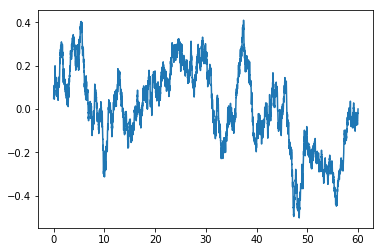

In [5]:
interval = 500
r_steps = steps//interval

r_sq = np.zeros(steps)
up = 0

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

r_combo = np.append(r_sin[:steps//2], r_sq[steps//2:])

### Plant control with neural network

In [6]:
pid = PID(1, 1, 1)

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]

u_delay = 10

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=())
    tf_u_offline = tf.placeholder(tf.float32,shape=(u_delay, ))
    tf_u_online = tf.placeholder(tf.float32,shape=(u_delay-1, ))

    tf_y = tf.placeholder(tf.float32,shape=())
    tf_e = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())

    def init_weights(layers, weights, biases):         
        for i in range(len(layers)):
            if i < len(layers) - 1:
                weights.append(tf.Variable(tf.truncated_normal([layers[i], layers[i+1]])))
                biases.append(tf.Variable(tf.zeros([layers[i+1]])))
            else:
                weights.append(tf.Variable(tf.truncated_normal([layers[i], 1])))
                biases.append(tf.Variable(tf.zeros([1])))
    # Model NN    
    #include input
    m_layers = [u_delay, 5, 3]
    m_weights = []
    m_biases = []
    init_weights(m_layers, m_weights, m_biases)

        
    # PID param NN
    #include input
    p_layers = [1, 3]

    Kp_weights = []
    Kp_biases = []
    
    Ki_weights = []
    Ki_biases = []
    
    Kd_weights = []
    Kd_biases = []
    
    init_weights(p_layers, Kp_weights, Kp_biases)
    init_weights(p_layers, Ki_weights, Ki_biases)
    init_weights(p_layers, Kd_weights, Kd_biases)

    def forward_prop(input_value, layers, weights, biases):
        for i in range(len(layers)):  
            if i == 0:
                z = tf.matmul(input_value, weights[i]) + biases[i]
            else:
                z = tf.matmul(a, weights[i]) + biases[i]
            if i < len(layers) - 1:
                a = tf.nn.leaky_relu(z)
        return z
        
    
    # Forward prop model offline
    y_model_offline = forward_prop(tf.reshape(tf_u_offline, (1, u_delay)), m_layers, m_weights, m_biases)
    
    # Forward prop PID
    e_rs = tf.reshape(tf_e, (1, 1))
    
    Kp = forward_prop(e_rs, p_layers, Kp_weights, Kp_biases)
    Ki = forward_prop(e_rs, p_layers, Ki_weights, Ki_biases)
    Kd = forward_prop(e_rs, p_layers, Kd_weights, Kd_biases)
    
    Kp_abs = tf.math.abs(Kp)
    Ki_abs = tf.math.abs(Ki)
    Kd_abs = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp_abs, Ki_abs, Kd_abs)
#     u_nn = tf_update(Kp, Ki, Kd)

    
    # Forward prop model online
    y_model_online = forward_prop(tf.concat([tf.reshape(tf_u_online, (1, u_delay-1)), u_nn], axis=1), 
                                  m_layers, m_weights, m_biases)
    
    model_var_list = m_weights + m_biases
    model_loss = tf.losses.mean_squared_error(tf_y, tf.reshape(y_model_offline, ()))
    model_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(model_loss, var_list=model_var_list)

    pid_var_list = Kp_weights + Kp_biases + Ki_weights + Ki_biases + Kd_weights + Kd_biases
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model_online, ()))
    pid_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(pid_loss, var_list=pid_var_list)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.


In [7]:
epochs = 10

y_0 = 0
t_prev = 0
y_p_offline = np.zeros(steps)
y_m_offline = np.zeros(steps)

y_p_online = np.zeros(steps)
y_m_online = np.zeros(steps)
u_offline = np.zeros(steps)
u_online = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

offline_loss = np.zeros(steps * epochs)
online_loss = np.zeros(steps * epochs) 

r_offline = r_sq
r_online = r_sq


offline_lr = 0.001
online_lr = 0.001


with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
       
        #Reset values
        y_0 = 0
        t_prev = 0
        y_p_offline = np.zeros(steps)
        y_m_offline = np.zeros(steps)
        u_offline = np.zeros(steps)
        
        print("Start epoch", j)
        for i in range(steps):
            
            e = r_offline[i] - y_0
            
            t_cur = t[i]
            pid.set_state(e, t_cur)
            u_offline[i] = pid.update()
            # Get plant output
            y_p_offline[i] = plant(y_0, t_prev, t_cur, u_offline)

            #Get u_delay number of past u values (including one just generated)
            if i+1 >= u_delay:
                u_delayed = u_offline[i+1-u_delay:i+1]
            else:
                u_delayed = np.concatenate((np.zeros(u_delay-i-1), u_offline[:i+1]))

            # Train model on plant output
            feed_dict = {tf_y:y_p_offline[i], tf_u_offline:u_delayed, tf_learning_rate:offline_lr}
            _, offline_loss[i + j*steps], y_m_offline[i] = session.run([model_opt, model_loss, y_model_offline], 
                                                             feed_dict=feed_dict)

            y_0 = y_p_offline[i]
            t_prev = t[i]
            
        print("Offline loss", sum(offline_loss[j * steps:i + j*steps])/(i + j*steps))

        #Reset values
        y_0 = 0
        t_prev = 0
        y_p_online = np.zeros(steps)
        y_m_online = np.zeros(steps)
        u_online = np.zeros(steps)
        
        for i in range(steps):  

            e = r_online[i] - y_0
            t_cur = t[i]
            pid.set_state(e, t_cur)


            #Get u_delay-1 number of past u values (not including current time step)
            if i >= u_delay-1:
                u_delayed = u_online[i-(u_delay-1):i]
            else:
                u_delayed = np.concatenate((np.zeros((u_delay-1)-i), u_online[:i]))
                
            # Get get PID parameters and get control signal
            # Send to model to train PID param NN
            feed_dict = {tf_e:e, tf_r:r_online[i], tf_u_online:u_delayed, tf_learning_rate:online_lr}
            _, online_loss[i + j*steps], y_m_online[i], u_online[i] = session.run([pid_opt, pid_loss, 
                                                                                   y_model_online, u_nn], 
                                                                                    feed_dict=feed_dict)
            y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
            y_0 = y_p_online[i]
            t_prev = t[i]
            
        print("Online loss", sum(online_loss[j * steps:i + j*steps])/(i + j*steps))

    #Reset values
    y_0 = 0
    t_prev = 0
    y_p_online = np.zeros(steps)
    y_m_online = np.zeros(steps)
    u_online = np.zeros(steps)
    
    for i in range(steps):  
        
        e = r_online[i] - y_0
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        
        if i >= u_delay-1:
            u_delayed = u_online[i-(u_delay-1):i]
        else:
            u_delayed = np.concatenate((np.zeros((u_delay-1)-i), u_online[:i]))

        feed_dict = {tf_e:e, tf_r:r_online[i], tf_u_online:u_delayed}
        y_m_online[i], u_online[i] = session.run([y_model_online, u_nn], feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
        y_0 = y_p_online[i]
        t_prev = t[i]

Start epoch 0
Offline loss 441.05519699366295
Online loss 1.936334002744407
Start epoch 1
Offline loss 3.928073248650563
Online loss 0.17925877460967618
Start epoch 2
Offline loss 1.0701987326421478
Online loss 22.68095612474028
Start epoch 3
Offline loss 0.23277083444803712
Online loss 1.549239682126957
Start epoch 4
Offline loss 0.052105571116957655
Online loss 0.9165008474939789
Start epoch 5
Offline loss 0.014865730862439664
Online loss 0.03516783669439123
Start epoch 6
Offline loss 0.0050919407475984255
Online loss 0.08387390488264544
Start epoch 7
Offline loss 0.00247807679200333
Online loss 0.06810860211438331
Start epoch 8
Offline loss 0.0014720956290622136
Online loss 0.05755463718734831
Start epoch 9
Offline loss 0.0012296496603274914
Online loss 0.15421520215008888


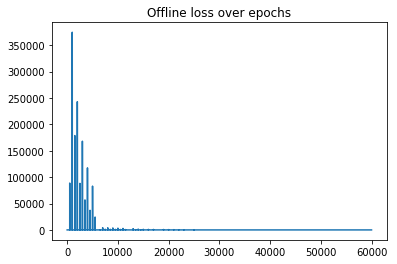

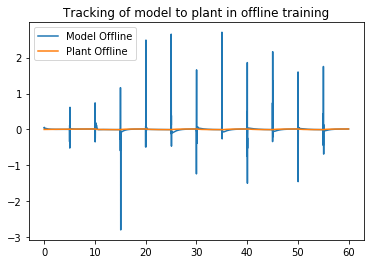

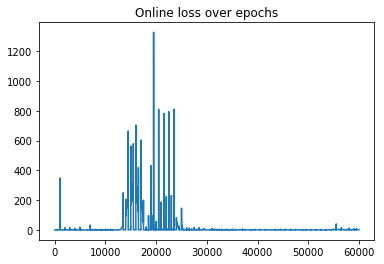

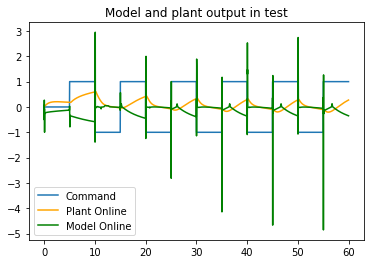

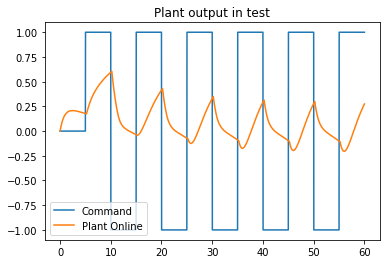

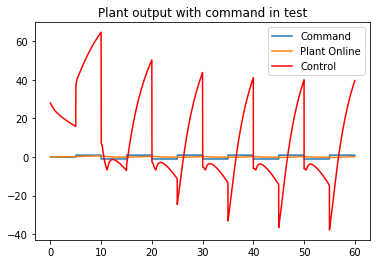

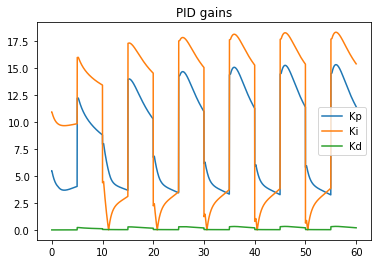

In [8]:
plt.plot(offline_loss)
plt.title('Offline loss over epochs')
plt.show()

plt.plot(t, y_m_offline)
plt.plot(t, y_p_offline)
plt.title('Tracking of model to plant in offline training')
plt.legend(('Model Offline', 'Plant Offline'))
plt.show()

plt.plot(online_loss)
plt.title('Online loss over epochs')
plt.show()

plt.plot(t, r_online)
plt.plot(t, y_p_online, color='orange')
plt.plot(t, y_m_online, color='green')
plt.title('Model and plant output in test')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r_online)
plt.plot(t, y_p_online)
plt.title('Plant output in test')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r_online)
plt.plot(t, y_p_online)
plt.plot(t, u_online, color='red')
plt.title('Plant output with command in test')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()